In [1]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps

In [13]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
# importation du datasets et definitions des colonnes
dataset = pd.read_csv('./datasets/mushrooms1.csv',header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor',
                   'gill-attachment','gill-spacing','gill-size','gill-color',
                   'stalk-shape','stalk-root','stalk-surface-above-ring',
                   'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring',
                   'veil-type','veil-color','ring-number','ring-type','spore-print-color',
                   'population','habitat']

In [6]:
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)
X = dataset.drop('target',axis=1)
Y = dataset['target'].where(dataset['target']==1,-1)
predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])
print('The accuracy is: ',predictions*100,'%')


The accuracy is:  73.0575127973502 %


In [3]:
dataset.head()

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4554,p,x,y,y,f,f,f,c,b,h,...,k,n,p,p,w,o,l,h,v,d
1012,e,x,s,w,f,n,f,w,b,k,...,s,w,w,p,w,o,e,k,s,g
6609,p,k,y,n,f,y,f,c,n,b,...,s,p,p,p,w,o,e,w,v,d
7642,e,b,s,g,f,n,f,w,b,p,...,s,w,w,p,w,t,p,w,s,g
8049,p,k,s,n,f,y,f,c,n,b,...,k,w,p,p,w,o,e,w,v,d


In [9]:
class Boosting:
    def __init__(self,dataset,T,test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None
    def fit(self):
    # Set the descriptive features and the target feature
        X = self.dataset.drop(['target'],axis=1)
        Y = self.dataset['target'].where(self.dataset['target']==1,-1)
        Evaluation = pd.DataFrame(Y.copy())
        Evaluation['weights'] = 1/len(self.dataset)
        alphas = []
        models = []
        for t in range(self.T):
        # Train the Decision Stump(s)
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) 
            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights']))
            models.append(model)
            predictions = model.predict(X)
            score = model.score(X,Y)
            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['target'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['target'],1,0)
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])
            # Caclulate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)
            # Update the weights wi --> These updated weights areused in the sample_weight parameter
            # for the training of the next decision stump.
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])
        #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
        #print('The missclassification rate is: ',misclassification*100,'%')
        self.alphas = alphas
        self.models = models
    def predict(self):
        X_test = self.test_dataset.drop(['target'],axis=1).reindex(range(len(self.test_dataset)))
        Y_test = self.test_dataset['target'].reindex(range(len(self.test_dataset))).where(self.dataset['target']==1,-1)
        # With each model in the self.model list, make a prediction
        accuracy = []
        predictions = []
        for alpha,model in zip(self.alphas,self.models):
            prediction = alpha*model.predict(X_test) # We use the predict method for the single decisiontreeclassifier models in the list
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
            self.predictions = np.sign(np.sum(np.array(predictions),axis=0))



In [10]:
number_of_base_learners = 50
for i in range(number_of_base_learners):
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict()

With a number of  50 base models we receive an accuracy of  98.67076923076922 %


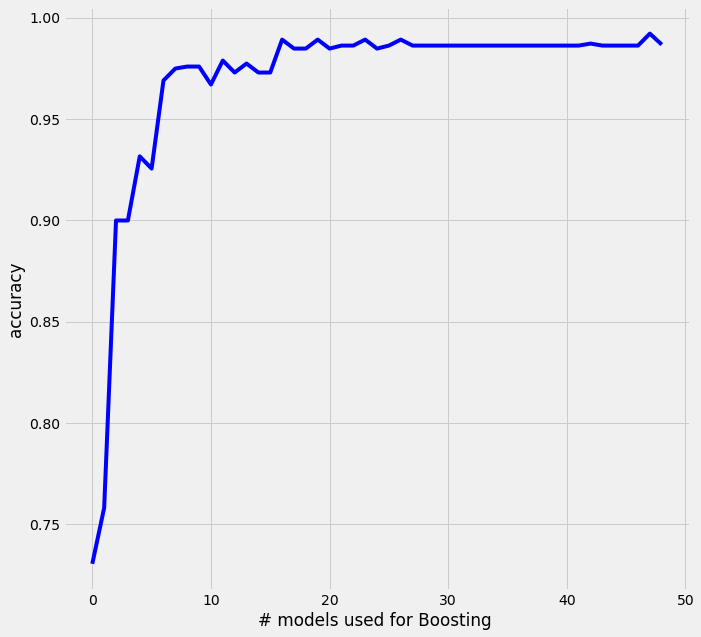

In [14]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.plot(range(len(model.accuracy)),model.accuracy,'-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')
plt.show()

In [15]:
from sklearn.ensemble import AdaBoostClassifier

#model = DecisionTreeClassifier(criterion='entropy',max_depth=1)
#AdaBoost = AdaBoostClassifier(base_estimator= model,n_estimators=400,learning_rate=1)
AdaBoost = AdaBoostClassifier(n_estimators=400,learning_rate=1,algorithm='SAMME')
AdaBoost.fit(X,Y)
prediction = AdaBoost.score(X,Y)
print('The accuracy is: ',prediction*100,'%')


The accuracy is:  100.0 %
